In [1]:
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
enableWGCNAThreads(nThreads = 40)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attach

Allowing parallel execution with up to 40 working processes.


In [2]:
packageDescription("hdWGCNA")$Version

[1] "0.4.00"

In [3]:
Myo_sub <- readRDS('./Myonuclei_subpopulation_seurat_v4.rds')

In [ ]:
Myo_sub$case_control <- as.character(Myo_sub$case_control)
Myo_sub$Myo_subcluster <- as.character(Myo_sub$Myo_subcluster)

Myo_sub$combined <- paste(Myo_sub$case_control, ":", Myo_sub$Myo_subcluster, sep = "")

Myo_sub$case_control <- as.factor(Myo_sub$case_control)
Myo_sub$Myo_subcluster <- as.factor(Myo_sub$Myo_subcluster)

In [5]:
Myo_sub$combined <- as.factor(Myo_sub$combined)

In [6]:
class(Myo_sub@assays$RNA)

[1] "Assay"
attr(,"package")
[1] "SeuratObject"

In [7]:
Myo_sub

An object of class Seurat 
50607 features across 76126 samples within 1 assay 
Active assay: RNA (50607 features, 0 variable features)
 2 layers present: counts, data
 8 dimensional reductions calculated: integrated.cca, myonuclei.integrated.cca, pca, tsne.integrated, tsne.integrated.cca, umap.integrated, umap.integrated.cca, umap.unintegrated

In [8]:
Myo_sub <- SetupForWGCNA(
	Myo_sub,
	gene_select = "fraction", # the gene selection approach
	fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
	wgcna_name = "Myonuclei_hdWGCNA" # the name of the hdWGCNA experiment
)

In [9]:
colnames(Myo_sub[[]])

[1] "nCount_RNA"                        "nFeature_RNA"                     
 [3] "nCount_spliced"                    "nFeature_spliced"                 
 [5] "nCount_unspliced"                  "nFeature_unspliced"               
 [7] "percent.mt"                        "percent.ribo"                     
 [9] "batch"                             "pANN_0.25_0.09_192"               
[11] "DF.classifications_0.25_0.09_192"  "pANN_0.25_0.09_494"               
[13] "DF.classifications_0.25_0.09_494"  "pANN_0.25_0.09_283"               
[15] "DF.classifications_0.25_0.09_283"  "pANN_0.25_0.09_246"               
[17] "DF.classifications_0.25_0.09_246"  "pANN_0.25_0.09_231"               
[19] "DF.classifications_0.25_0.09_231"  "pANN_0.25_0.09_332"               
[21] "DF.classifications_0.25_0.09_332"  "pANN_0.25_0.09_356"               
[23] "DF.classifications_0.25_0.09_356"  "pANN_0.25_0.09_533"               
[25] "DF.classifications_0.25_0.09_533"  "pANN_0.25_0.09_459"               
[27] "DF.classifications_0.25_0.09_459"  "pANN_0.25_0.09_565"               
[29] "DF.classifications_0.25_0.09_565"  "pANN_0.25_0.09_537"               
[31] "DF.classifications_0.25_0.09_537"  "pANN_0.25_0.09_455"               
[33] "DF.classifications_0.25_0.09_455"  "case_control"                     
[35] "percent.hb"                        "S.Score"                          
[37] "G2M.Score"                         "Phase"                            
[39] "old.ident"                         "unintegrated_clusters"            
[41] "seurat_clusters"                   "cca_clusters"                     
[43] "cell_type"                         "myonuclei.integrated.cca.clusters"
[45] "Myo_subcluster"                    "combined"

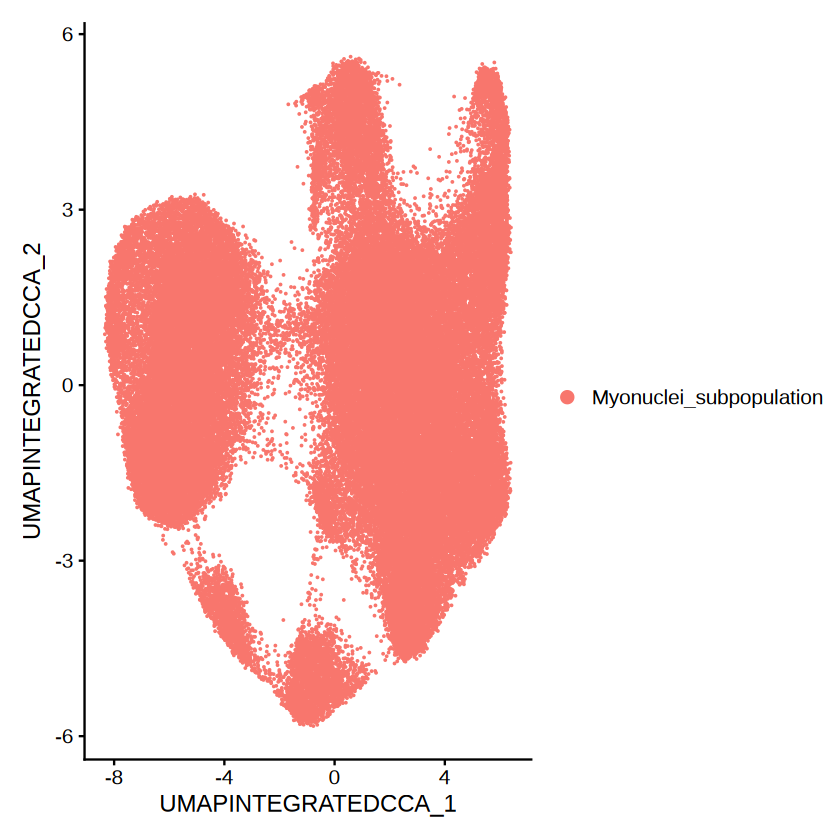

In [10]:
DimPlot(Myo_sub, reduction = 'umap.integrated.cca')

In [11]:
# construct metacells  in each group
Myo_sub <- MetacellsByGroups(
	seurat_obj = Myo_sub,
	group.by = c("case_control","combined"), # specify the columns in seurat_obj@meta.data to group by
	reduction = 'umap.integrated.cca', # select the dimensionality reduction to perform KNN on
	k = 25, # nearest-neighbors parameter
	max_shared = 10, # maximum number of shared cells between two metacells
	ident.group = 'combined' # set the Idents of the metacell seurat object
)

# normalize metacell expression matrix:
Myo_sub <- NormalizeMetacells(Myo_sub)

In [12]:
Idents(Myo_sub) <- 'combined'
Myo_sub <- SetDatExpr(
	Myo_sub,
	group_name = levels(Myo_sub), # the name of the group of interest in the group.by column
	group.by='combined', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
	assay = 'RNA', # using RNA assay
	slot = 'data' # using normalized data
)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”


pickSoftThreshold: will use block size 2751.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2751 of 2751


   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k.  max.k.
1      1    0.659 13.00          0.606 1.41e+03  1.43e+03 1480.00
2      2    0.042  1.59         -0.142 7.33e+02  7.55e+02  831.00
3      3    0.149 -2.94          0.358 3.86e+02  4.00e+02  486.00
4      4    0.384 -4.34          0.734 2.06e+02  2.13e+02  294.00
5      5    0.574 -4.64          0.894 1.11e+02  1.14e+02  184.00
6      6    0.699 -4.38          0.953 6.07e+01  6.18e+01  118.00
7      7    0.789 -3.93          0.965 3.35e+01  3.36e+01   77.70
8      8    0.865 -3.70          0.968 1.88e+01  1.84e+01   53.50
9      9    0.906 -3.47          0.971 1.06e+01  1.01e+01   38.00
10    10    0.939 -3.12          0.964 6.10e+00  5.57e+00   27.80
11    12    0.983 -2.71          0.979 2.11e+00  1.73e+00   16.30
12    14    0.992 -2.30          0.991 7.86e-01  5.52e-01   10.70
13    16    0.986 -1.98          0.982 3.21e-01  1.81e-01    7.53
14    18    0.942 -1.79          0.926 1.47e-01  6.03e-02    5.64
15    20  

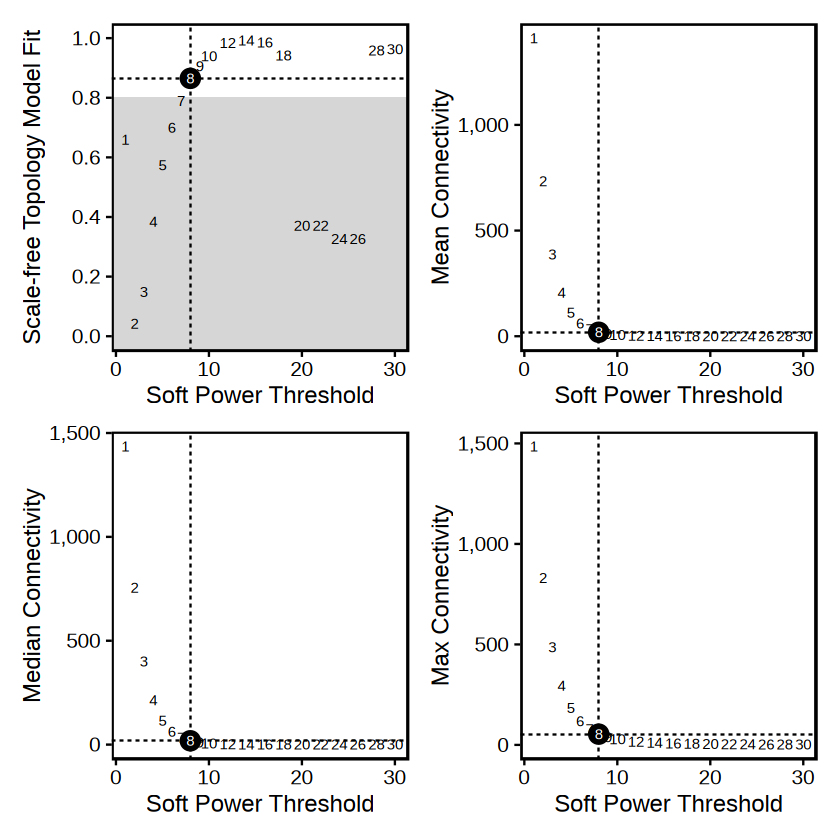

In [13]:
# Test different soft powers:
Myo_sub <- TestSoftPowers(
	Myo_sub,
	networkType = 'signed' # you can also use "unsigned" or "signed hybrid"
)

# plot the results:
plot_list <- PlotSoftPowers(Myo_sub)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

In [14]:
power_table <- GetPowerTable(Myo_sub)
head(power_table)

,Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.65939759,12.973870,0.6064724,1410.41557,1434.9364,1484.6388
2,2,0.04198093,1.588137,-0.1417352,733.31664,754.8261,831.0434
3,3,0.14858253,-2.943507,0.3580681,386.21606,400.0363,486.2972
4,4,0.38410052,-4.341344,0.7339460,205.92962,213.4109,294.3793
5,5,0.57353933,-4.642705,0.8935767,111.12162,114.4559,183.6979
6,6,0.69942799,-4.375501,0.9531726,60.67377,61.8156,117.8936


Warning message in ConstructNetwork(Myo_sub, soft_power = 8, setDatExpr = FALSE, :
“Overwriting TOM TOM/Myo_subpopulation_TOM.rda”


 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1


    TOM calculation: adjacency..
    ..will use 40 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


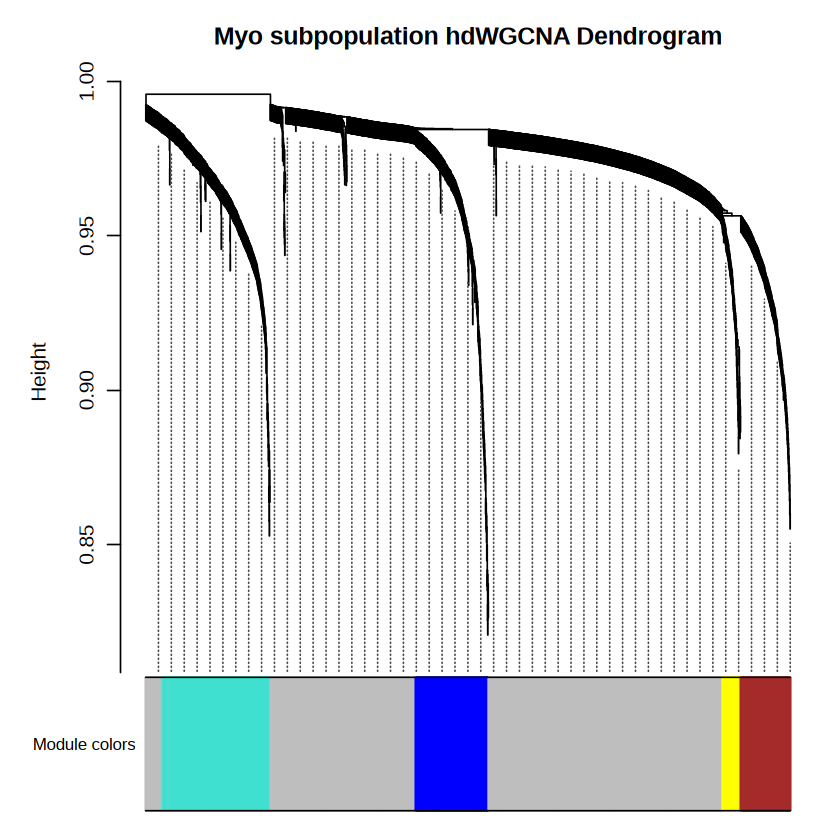

In [ ]:
Myo_sub <- ConstructNetwork(
  Myo_sub, 
  soft_power=8,
  setDatExpr=FALSE,
  corType = "pearson",
  networkType = "signed",
  TOMType = "signed",
  detectCutHeight = 0.99,# default is 0.995
  minModuleSize = 40, # default is 50
  mergeCutHeight = 0.2,
  tom_outdir = "TOM", 
  overwrite_tom = TRUE,
  tom_name = 'Myo_subpopulation' # name of the topoligical overlap matrix written to disk
)
PlotDendrogram(Myo_sub, main='Myo subpopulation hdWGCNA Dendrogram')

In [21]:
Myo_sub@misc$active_wgcna <- "Myonuclei_hdWGCNA"

In [19]:
Myo_sub@misc$active_wgcna

[1] "Myonuclei_hdWGCNA"

In [23]:
wgcna_name <- 'Myonuclei_hdWGCNA'

In [ ]:
Myo_sub <- ScaleData(Myo_sub,features=VariableFeatures(Myo_sub))
Myo_sub <- ModuleEigengenes(
     Myo_sub,
     scale.model.use="linear",
     assay = NULL,
     pc_dim = 1)

hMEs <- GetMEs(Myo_sub)
MEs <- GetMEs(Myo_sub, harmonized=FALSE)

Centering and scaling data matrix



[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
pcagrey_ 1 
Positive:  Rgcc, P4hb, Tnfaip2, Fhod1, Cish, Pik3r1, Hspb1, Canx, Cdk11b, Camk1d 
	   Lmna, Chd4, Timm22, Hspb6, Fkbp4, Rhoa, Azin1, Mapkapk2, Exoc7, Jun 
	   Fitm2, Dupd1, Clpp, Psma7, Itm2b, Pttg1, Dld, Smim20, Hexa, Plaat3 
Negative:  Gm10800, Ttn, mt-Co1, Asb2, Galnt2l, Myl1, mt-Nd2, mt-Cytb, Mylk2, Myoz1 
	   Ucp3, mt-Nd4, Gm21738, Pygm, Ankrd23, Rabep2, Pdk4, Cmya5, A930016O22Rik, Dusp13 
	   Ube2c, Rilpl1, Art1, Ksr1, Gm28376, Cmss1, Reep1, Gm10722, mt-Ts1, mt-Nd6 
pcagrey_ 2 
Positive:  mt-Co1, mt-Cytb, mt-Nd4, Ube2c, mt-Nd2, Asb2, A930016O22Rik, Pdk4, Gm10800, mt-Ts1 
	   Rabep2, mt-Nd5, Pygm, mt-Nd6, mt-Atp8, Ankrd23, Cmss1, Arrdc2, Ucp3, Myoz1 
	   Mylk2, Fbxo32, Rilpl1, mt-Nd3, Gm10801, Gm15441, Smox, Gm21738, Galnt2l, Klhl33 
Negative:  5430431A17Rik, Lama2, Dlg2, Gprc5c, Ankrd10, Macf1, Resf1, 

[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
pcablue_ 1 
Positive:  Ppp1r10, Slc25a23, Kif3a, Hexb, Rdh14, Mob1b, Irak2, Arhgap24, 2610037D02Rik, Plekha5 
	   Atpaf1, Ppp3cc, Klhl7, Gpc4, Pik3ca, Dhx32, Myl12b, Atad1, Trim35, Bhlhe40 
	   Tsc22d1, C2cd5, Chkb, Kif21a, 1810013L24Rik, Lyrm4, Gm11266, Wdr37, Pdpk1, Slc25a42 
Negative:  Vegfa, Actn2, Fhl1, Ckmt2, Mybpc1, Agbl1, Ank2, Esrrg, Ptpn3, Hk2 
	   Ugp2, Qk, Nr4a3, Atp1b1, Sorbs1, Adk, Tead1, Prkg1, Gys1, Nr4a1 
	   Ppargc1a, Hs3st5, Tbc1d1, Flnc, Lmcd1, Ldb3, Myom1, Ankrd2, 2310016D03Rik, Cd36 
pcablue_ 2 
Positive:  Agbl1, Ank2, Nrp1, Cd36, Gm49513, 2310016D03Rik, Pitpnc1, Pnpla3, Esrrg, Rmdn1 
	   Fgf1, Atp1a2, Aldh1a1, Zfp385b, Lpl, Pptc7, Kcnq5, Adk, Kcnn2, Cpt1b 
	   Rcan2, Gm42970, Fam13a, Coq8a, Slc38a3, Pacs1, Angpt1, B3galt1, Gbe1, Gpc4 
Negative:  Nr4a3, Hk2, Ugp2, Actn2, Flnc, Asb5, Slc38a2, Nr4a1,

[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
pcaturquoise_ 1 
Positive:  Ahnak, St13, Apoe, Metap1, Mt2, Ndfip1, Bnip2, Mrps28, Inpp5a, Eif3a 
	   Ier3ip1, Prmt1, Ubr4, Nudcd3, Cfl2, Map1lc3b, Hsp90b1, Paip2, Arpp19, Jtb 
	   Rdx, Serinc3, Vapa, Emc3, Pfdn2, Tfrc, Cyb5r1, Fxr2, Snrpd3, Mt1 
Negative:  Ckm, Acta1, Myh4, Tnnc2, Tnni2, Pvalb, Tnnt3, Pgam2, Mylpf, Atp2a1 
	   Eno3, Aldoa, Tpm1, Actn3, Tcap, Slc25a4, Des, mt-Rnr2, Rplp1, Hsp90ab1 
	   Tpt1, Ldha, Tpm2, Cox4i1, mt-Nd1, Atp5e, Chchd2, Mb, Gapdh, Uqcr11 
pcaturquoise_ 2 
Positive:  Aldoa, Tpm1, Tnnc2, mt-Nd1, Tnni2, Actn3, Gapdh, Tnnt3, Pfkm, Myh4 
	   Mylpf, Pkm, Tmem38a, Tpm2, Acta1, Pvalb, Eno3, Mybpc2, Cox6a2, Casq1 
	   Ldha, Slc25a4, mt-Rnr1, Ndrg2, Atp5j, Ubc, Car3, Atp5a1, Vdac1, Calm1 
Negative:  Rplp1, Hspb8, Chchd2, Atp2a1, Cavin1, Rpl38, Eef1a1, Col1a1, Mgp, Rps9 
	   S100a6, Rpl36al

[1] "yellow"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
pcayellow_ 1 
Positive:  Acsl3, Tmem87a, Pcx, E130308A19Rik, Dop1b, Gm16364, Setd7, Phf21a, Slc10a7, Sort1 
	   Mical2, Prkag3, Nedd4l, Eef2k, Atp8a1, Cdk19, Pde4b, Trp63, Camk2a, Tcf4 
	   Rc3h1, Plcd4, Bcl6, Cyp27a1, Sema3c, Stim2, Deptor, Ddi2, Lrrfip1, Celf2 
Negative:  Pde4d, Gm26740, Ampd1, Trdn, Phka1, Eya4, Jph1, Pfkfb3, Mylk4, Rbfox1 
	   Amd1, Sorbs2, Mbnl1, Rsrp1, Cpeb1, Gm43063, Ctnna3, Maf, Raet1e, Rora 
	   Sobp, Fmnl2, Hmgb1-ps8, Gpcpd1, Slc38a4, Ppp3ca, Cacna2d1, Setbp1, Ube2d1, Stxbp4 
pcayellow_ 2 
Positive:  Jak1, Maf, Ar, Eya4, Fmnl2, Gm16364, Deptor, Bcl6, Setd7, Calm2 
	   Pde4b, Pfkfb3, Plcd4, Pcx, Psme4, Nedd4l, Jph1, Sobp, Trp63, Sorbs2 

[1] "brown"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
pcabrown_ 1 
Positive:  Thoc2l, Mrtfb, Thoc2, Clic5, Hnrnpa1, Exd2, Tob1, Dcun1d1, Wdr33, Nktr 
	   5031425E22Rik, Ppp6r3, Pla2g4e, Srrm2, Gm42790, Nr1d2, Arid1b, Trpm7, Uty, Hipk2 
	   Abcc9, Mllt10, Rev3l, Dennd1a, Srek1, Dip2c, Ccdc58, Aopep, Prrc1, Ncor1 
Negative:  Dmd, Neb, Neat1, Zbtb20, Phkg1, Sox6, Filip1l, Rbm20, Pde4dip, Ddx5 
	   Nctc1, Obscn, Mef2c, Fgf13, Tacc2, Pdzrn3, Zbtb16, Ryr1, Ppp1r12b, Luc7l2 
	   Pdlim5, Ghr, Nexn, Map4, Mbnl2, Ank3, Sgcd, Acyp2, Ube2b, Actg1 
pcabrown_ 2 
Positive:  Neat1, Filip1l, Tacc2, Txnip, Gm37376, Osbpl9, Etl4, Nctc1, Fgfr2, Cped1 
	   Tnrc6b, Zfp638, Clasp2, Pde4dip, Cpeb3, Foxn3, Mast2, Mia2, Clk1, Acyp2 
	   Kcnma1, Ddx5, Pla2g4e, A330023F24Rik, Luc7l2, Gm15179, Ghr, Pnisr, Son, Dst 
Negative:  Pdlim3, Irs1, Cap2, Palld, Clic5, Atcayos, Mef2c, Mbnl2, Ano6, Arhgap10 
	

In [17]:
levels(Myo_sub$Myo_subcluster)

[1] "Hybrid IIb/IIx" "Specialized"    "Type IIa"       "Type IIb"      
[5] "Type IIx"

In [18]:
levels(Myo_sub$combined)

[1] "FLOX:Hybrid IIb/IIx" "FLOX:Specialized"    "FLOX:Type IIa"      
 [4] "FLOX:Type IIb"       "FLOX:Type IIx"       "KO:Hybrid IIb/IIx"  
 [7] "KO:Specialized"      "KO:Type IIa"         "KO:Type IIb"        
[10] "KO:Type IIx"

,gene_name,module,color,kME_grey,kME_Sub_Myo-M1,kME_Sub_Myo-M2
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
Gm37988,Gm37988,grey,grey,0.07489868,0.0186356335,0.02132291
Rb1cc1,Rb1cc1,grey,grey,0.10967531,0.0785932541,0.03698545
Pcmtd1,Pcmtd1,grey,grey,0.12107279,0.0294562980,0.05457750
Sntg1,Sntg1,grey,grey,0.09958368,0.0270989723,0.06542206
Arfgef1,Arfgef1,grey,grey,0.05005428,0.0052452622,0.03000722
Cspp1,Cspp1,grey,grey,0.07616572,-0.0001428063,0.03191839


[1] "grey"       "Sub_Myo-M1" "Sub_Myo-M2" "Sub_Myo-M3" "Sub_Myo-M4"


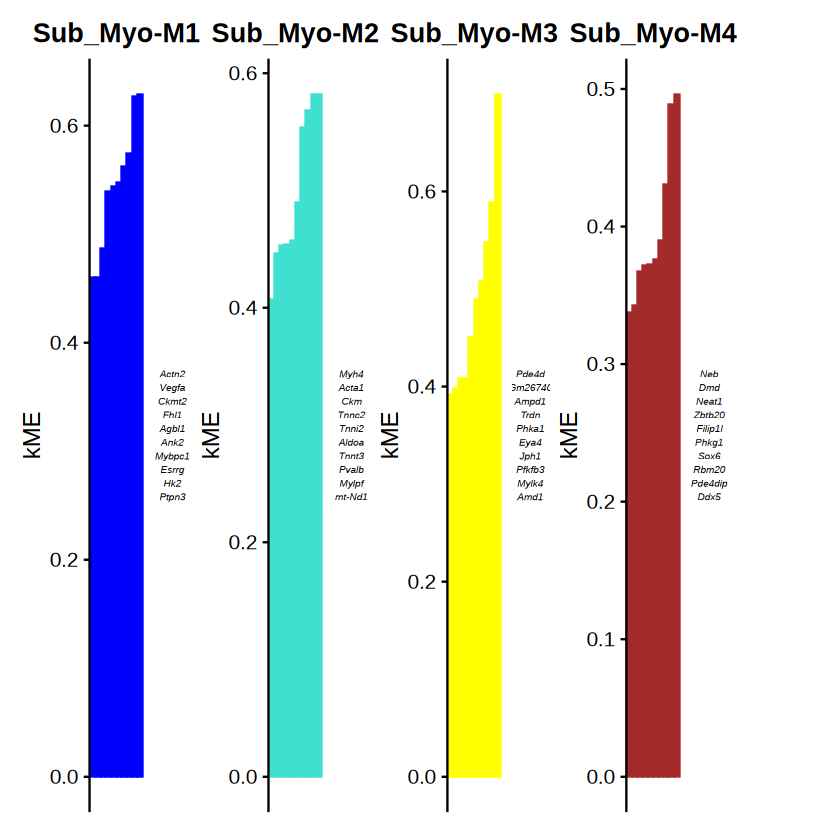

In [19]:
Myo_sub <- ModuleConnectivity(
  Myo_sub,
  group.by = 'combined', group_name = c('FLOX:Type IIa','FLOX:Type IIb','FLOX:Type IIx','KO:Type IIa','KO:Type IIb','KO:Type IIx'),corFnc="bicor",corOptions="use='p'",harmonized=TRUE,assay=NULL,slot="data"
)
Myo_sub <- ResetModuleNames(
  Myo_sub,
  new_name = "Sub_Myo-M"
)
modules<-GetModules(Myo_sub)
head(modules[,1:6])
print(levels(modules$module))
p <- PlotKMEs(Myo_sub, 
              ncol=5,
              n_hubs = 10, 
              text_size = 2,
              plot_widths = c(3, 2)) 
p

In [20]:
# get hub genes
hub_df <- GetHubGenes(Myo_sub, n_hubs = 10)

head(hub_df)

,gene_name,module,kME
,<chr>,<fct>,<dbl>
1,Actn2,Sub_Myo-M1,0.6291256
2,Vegfa,Sub_Myo-M1,0.6271561
3,Ckmt2,Sub_Myo-M1,0.5742111
4,Fhl1,Sub_Myo-M1,0.5623207
5,Agbl1,Sub_Myo-M1,0.5475270
6,Ank2,Sub_Myo-M1,0.5442856


In [22]:
Myo_sub

An object of class Seurat 
50607 features across 76126 samples within 1 assay 
Active assay: RNA (50607 features, 0 variable features)
 3 layers present: counts, data, scale.data
 8 dimensional reductions calculated: integrated.cca, myonuclei.integrated.cca, pca, tsne.integrated, tsne.integrated.cca, umap.integrated, umap.integrated.cca, umap.unintegrated

Selecting by kME_Sub_Myo-M1
Selecting by kME_Sub_Myo-M2
Selecting by kME_Sub_Myo-M3
Selecting by kME_Sub_Myo-M4


Selecting by kME_Sub_Myo-M1
Selecting by kME_Sub_Myo-M2
Selecting by kME_Sub_Myo-M3
Selecting by kME_Sub_Myo-M4


[1] "Sub_Myo-M1"
[1] "Sub_Myo-M2"
[1] "Sub_Myo-M3"
[1] "Sub_Myo-M4"
[1] "Sub_Myo-M1"
[1] "Sub_Myo-M2"
[1] "Sub_Myo-M3"
[1] "Sub_Myo-M4"


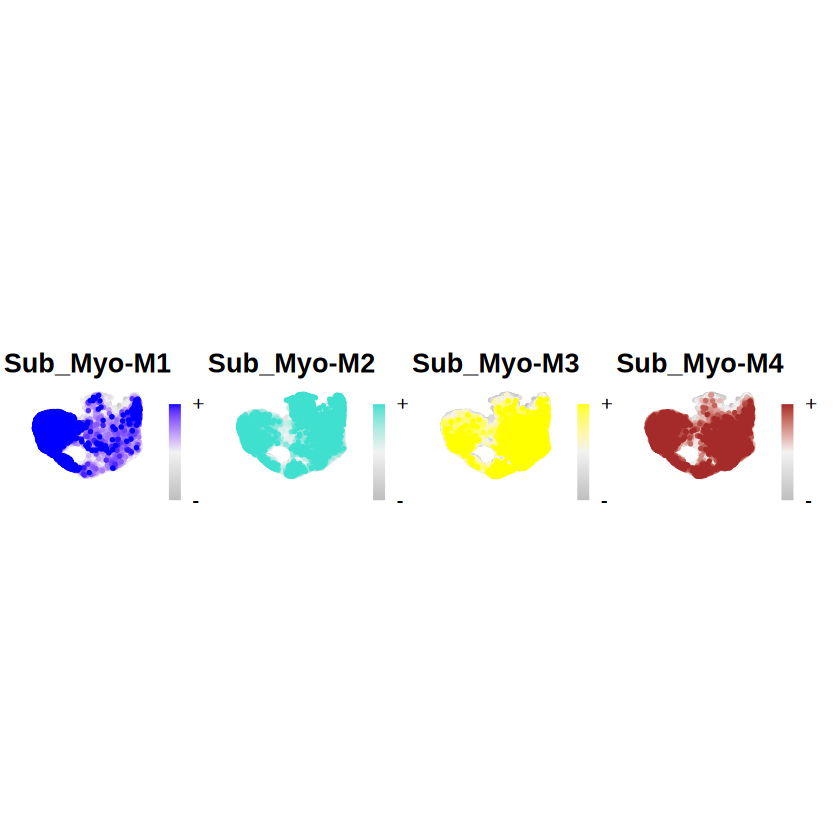

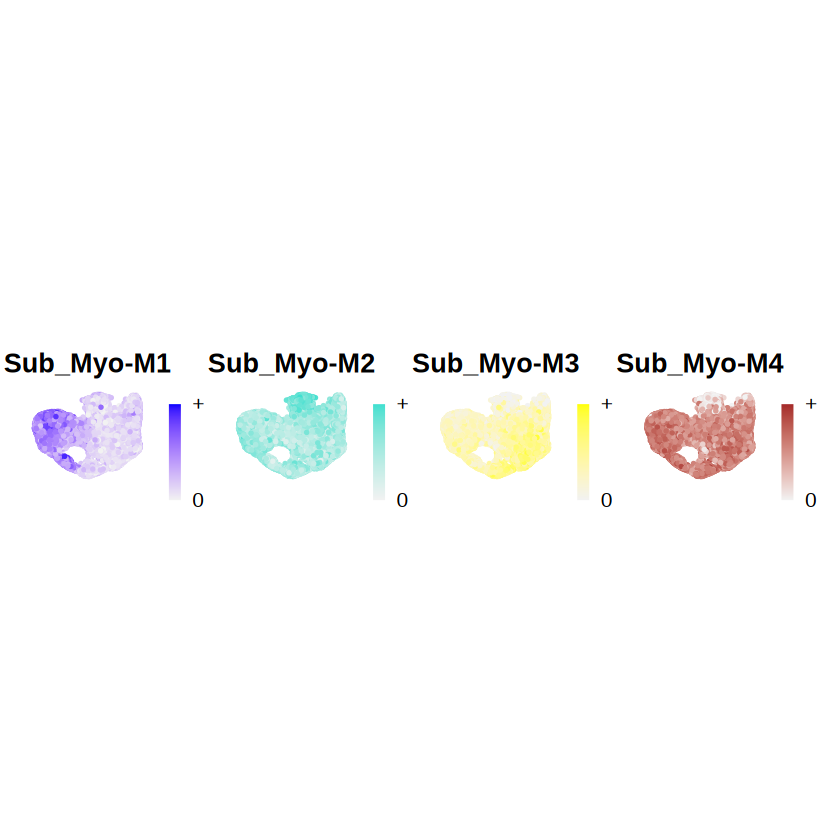

In [ ]:
Myo_sub <- ModuleExprScore(
  Myo_sub,
  n_genes = 25,
  method='Seurat'
)
library(UCell)
Myo_sub <- ModuleExprScore(
  Myo_sub,
  n_genes = 25,
  method='UCell'
)
plot_list <-ModuleFeaturePlot(
  Myo_sub,
  reduction = "umap.integrated.cca",
  features = "hMEs",
  order_points = TRUE, # order so the points with highest hMEs are on top
  restrict_range = TRUE,
  point_size = 0.5,
  alpha = 1,
  label_legend = FALSE,
  raster_dpi = 500,
  raster_scale = 1,
  plot_ratio = 1,
  title = TRUE
)
wrap_plots(plot_list, ncol=4)
plot_list <- ModuleFeaturePlot(
  Myo_sub,
  reduction = "umap.integrated.cca",
  features='scores', # plot the hub gene scores
  order='shuffle', # order so cells are shuffled
  ucell = TRUE # depending on Seurat vs UCell for gene scoring
)

# stitch together with patchwork
wrap_plots(plot_list, ncol=4)

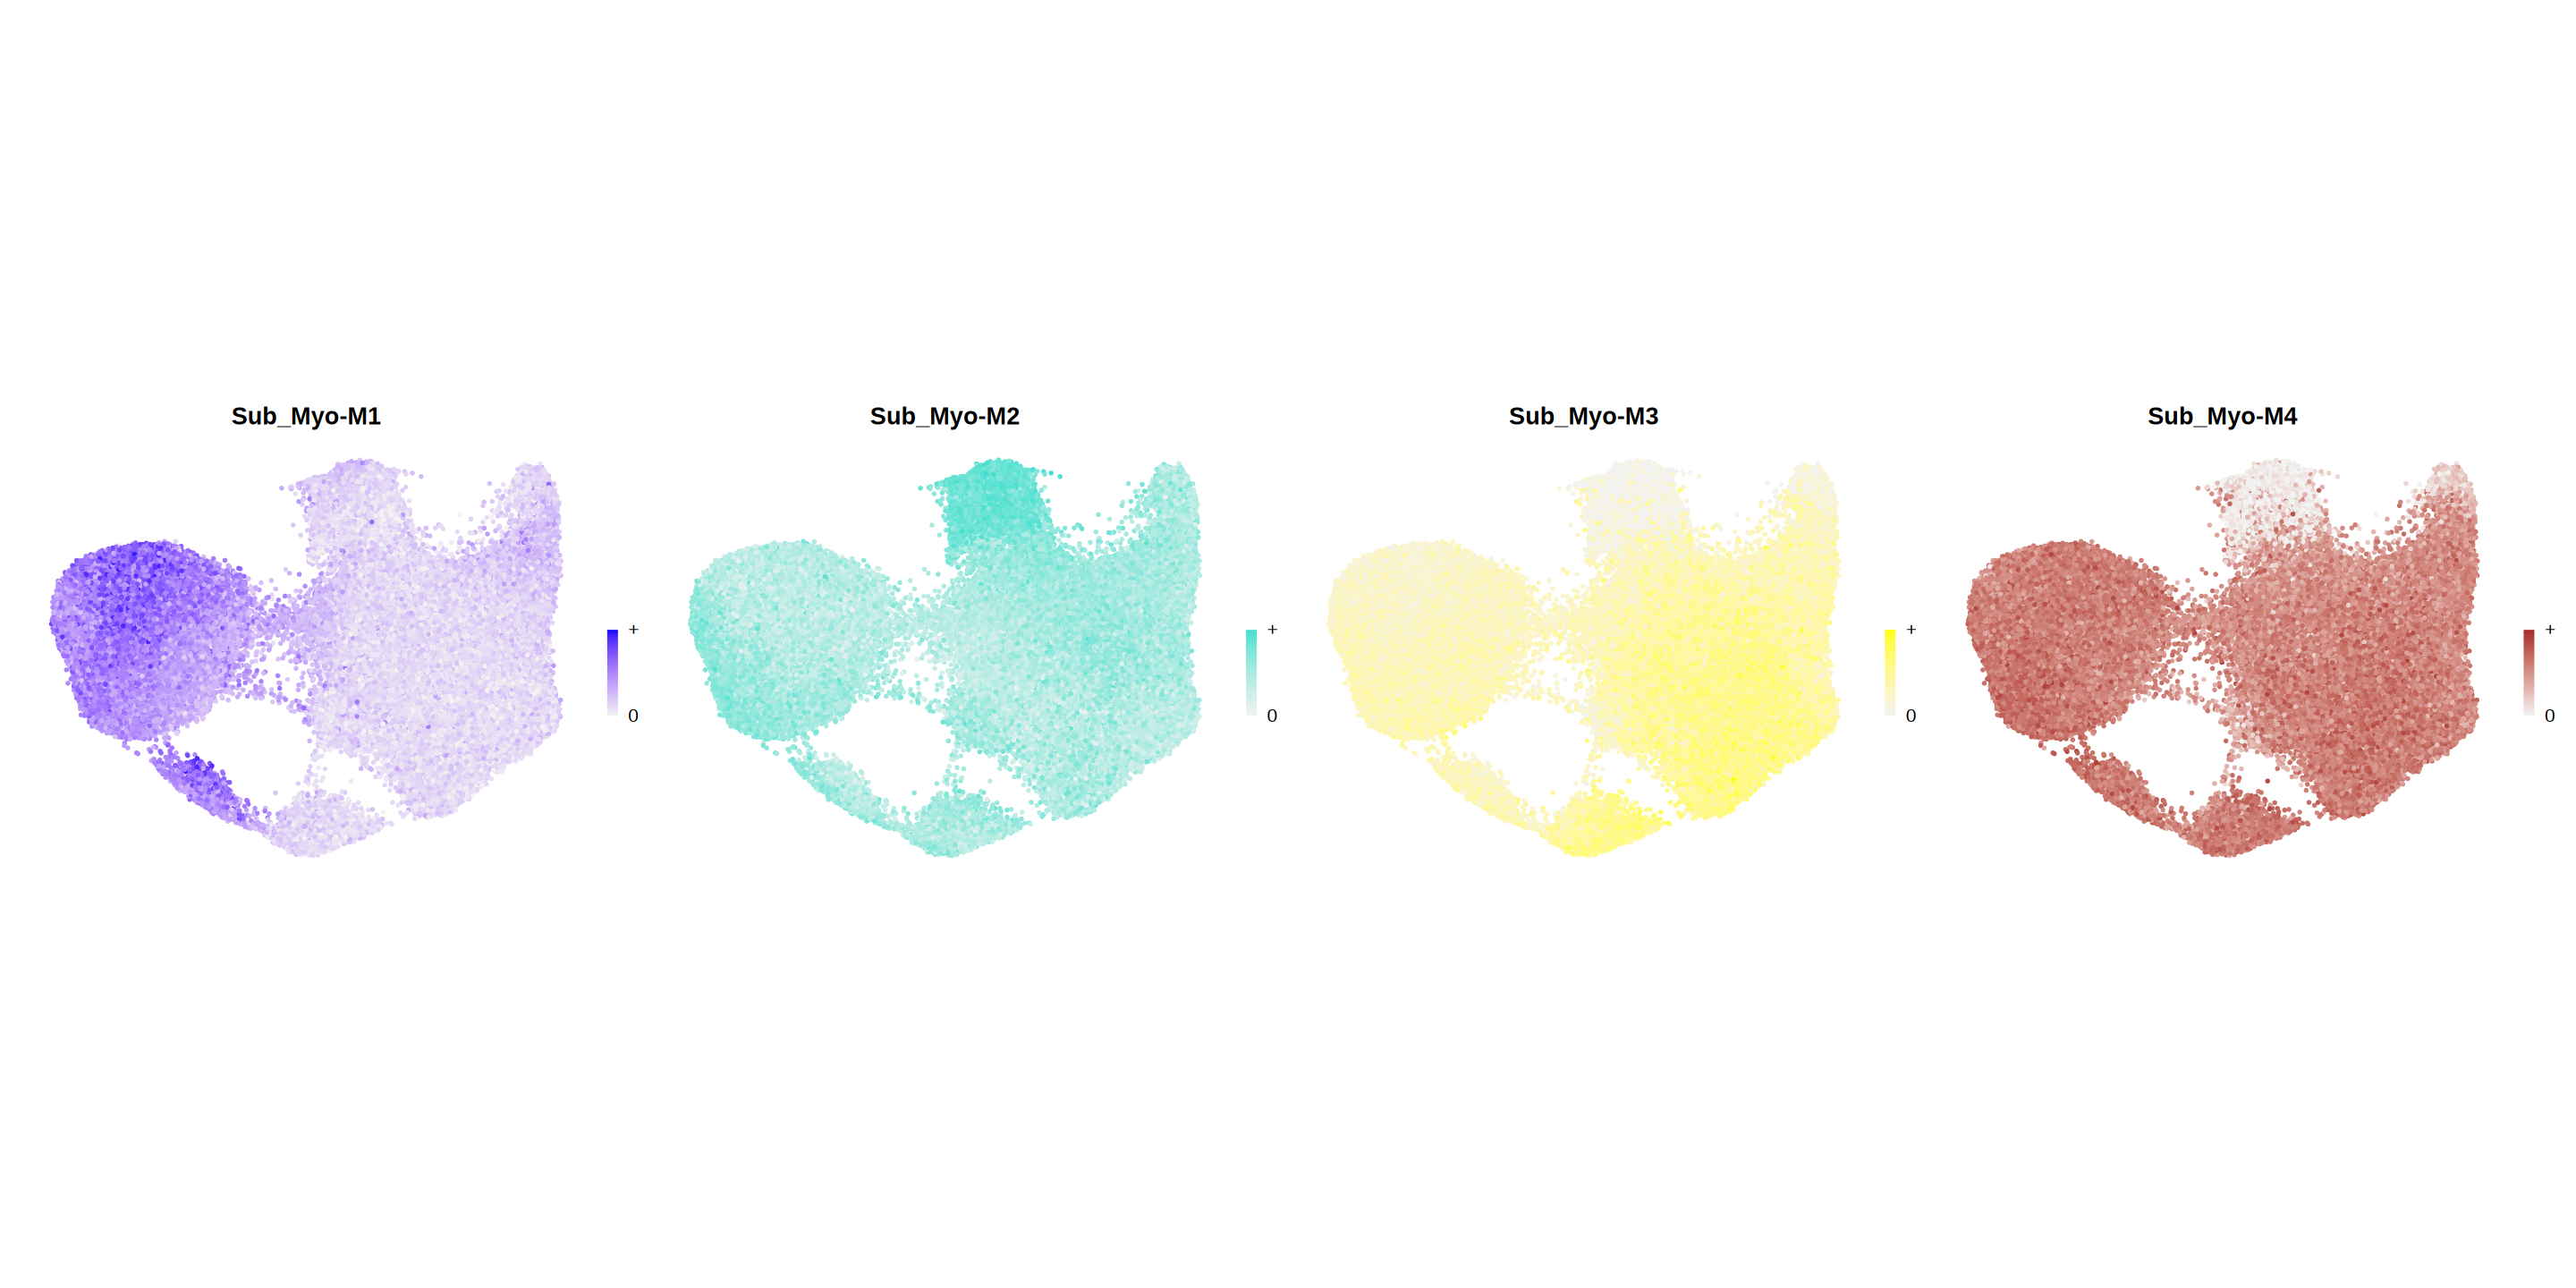

In [26]:
options(repr.plot.width = 24, repr.plot.height = 12)
wrap_plots(plot_list, ncol=4)

Warning message in pNew > sig.level:
“longer object length is not a multiple of shorter object length”


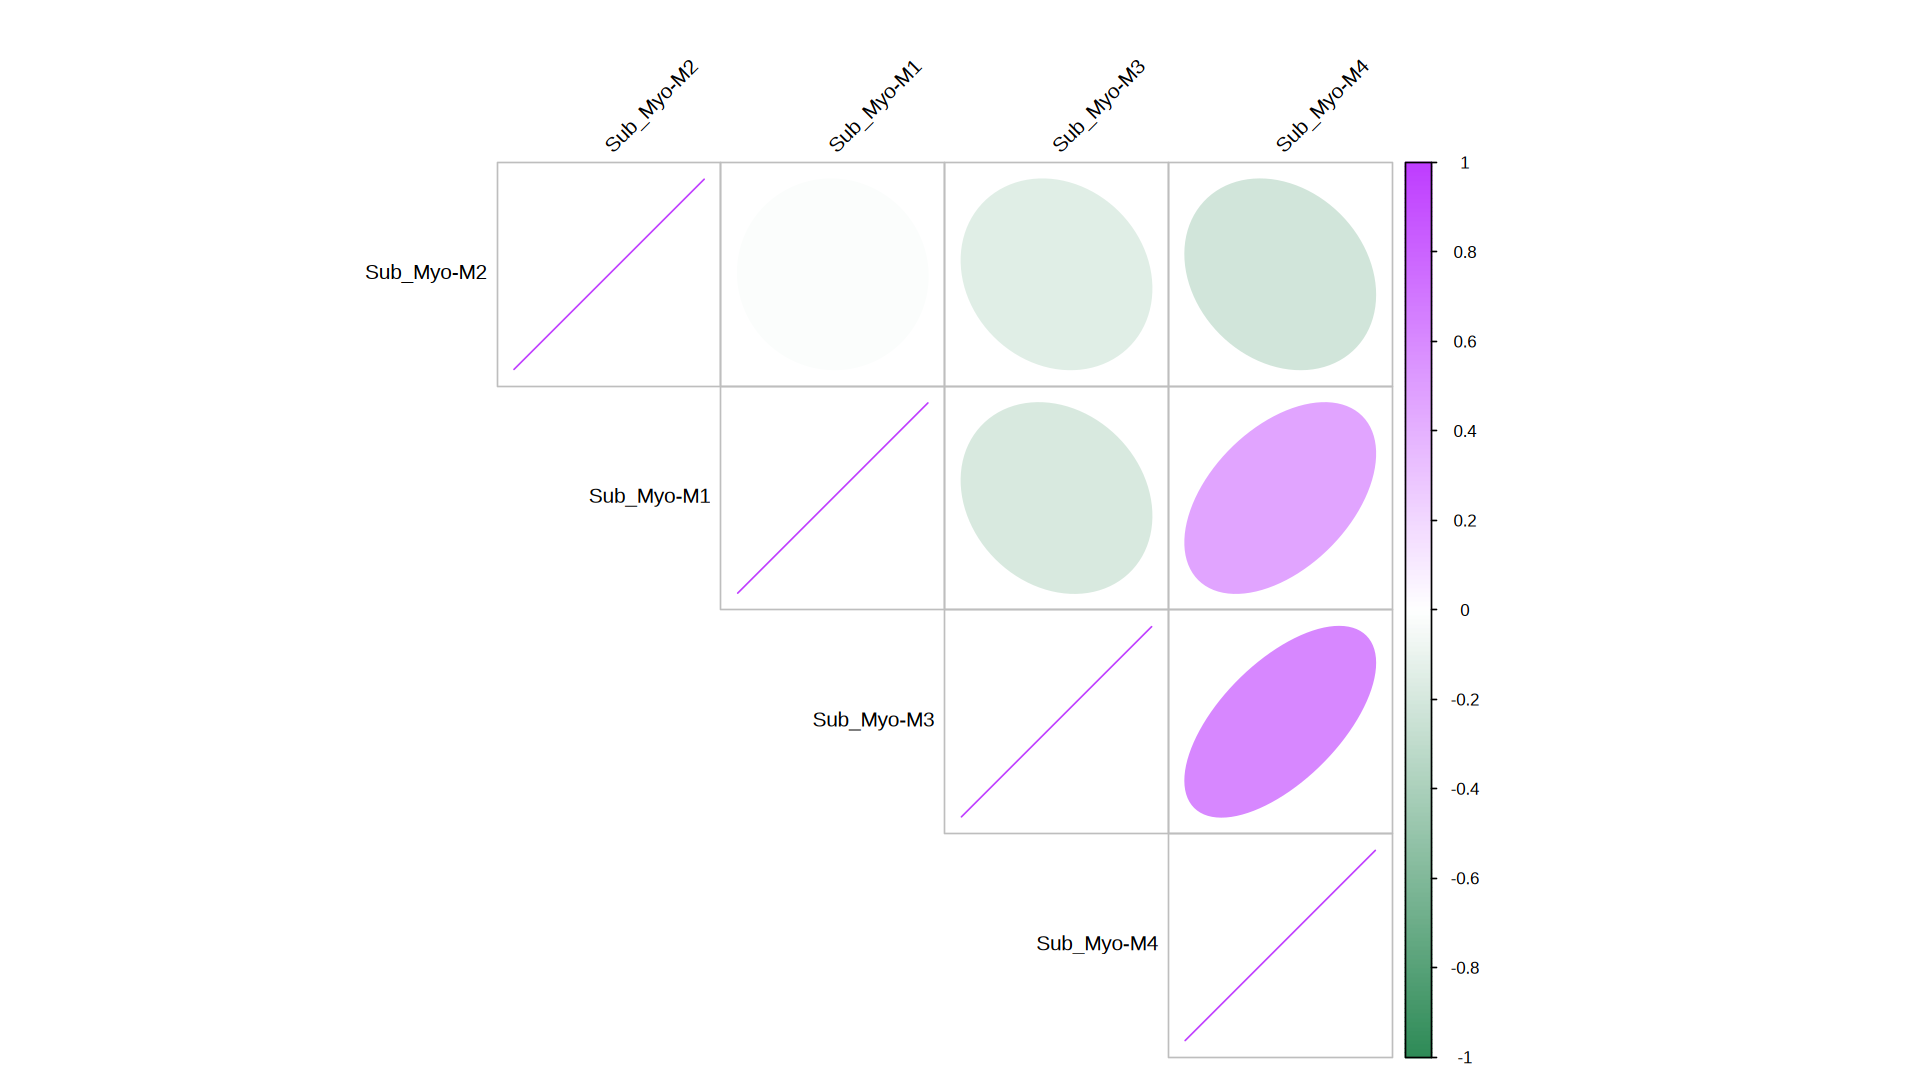

In [ ]:
ModuleCorrelogram(Myo_sub,
                  exclude_grey = TRUE,
                  features = "hMEs")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


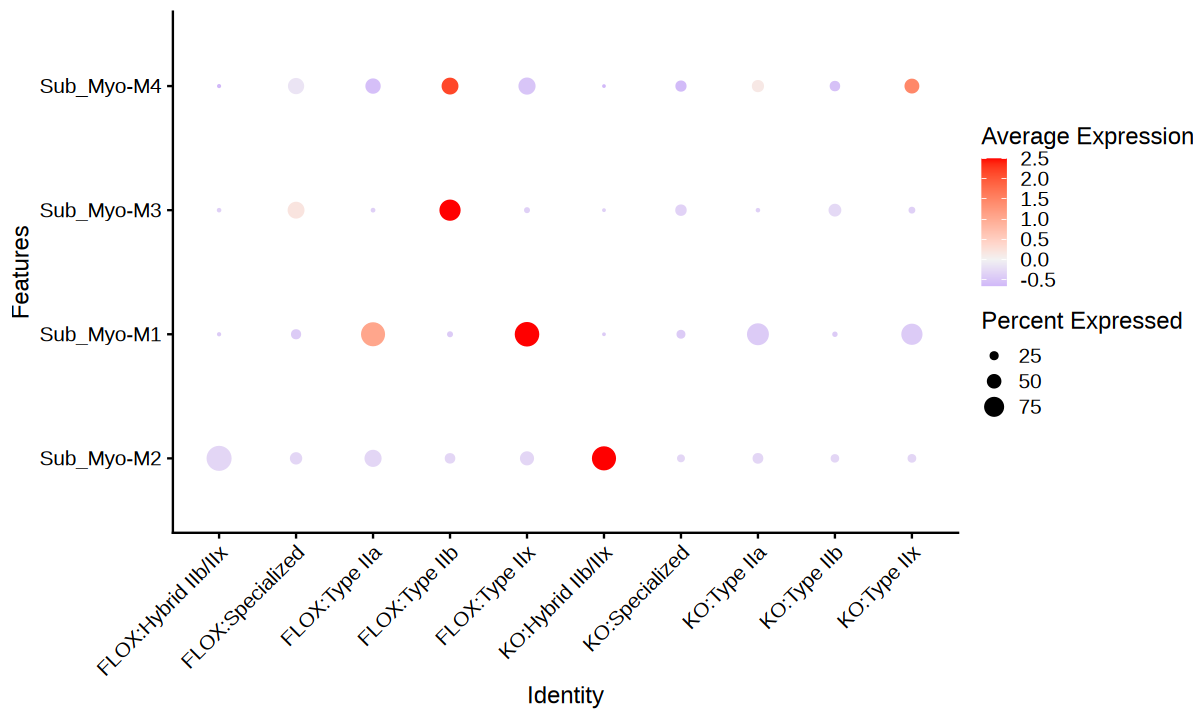

In [27]:
MEs <- GetMEs(Myo_sub, harmonized=TRUE)
mods <- colnames(MEs); mods <- mods[mods != 'grey']

# add hMEs to Seurat meta-data:
Myo_sub@meta.data <- cbind(Myo_sub@meta.data, MEs)
p <- DotPlot(Myo_sub, features=mods, group.by = 'combined')

# flip the x/y axes, rotate the axis labels, and change color scheme:
p <- p +
  coord_flip() +
  RotatedAxis() +
  scale_color_gradient2(high='red', mid='grey95', low='blue')

# plot output
options(repr.plot.width = 10, repr.plot.height = 6)
p

In [ ]:
library(igraph)
# Visualizes the top hub genes for selected modules as a circular network plot
p <- ModuleNetworkPlot(
  Myo_sub,
  mods = "all", # all modules are plotted.
  outdir = "ModuleNetworks", # The directory where the plots will be stored.
  plot_size = c(6, 6),
  label_center = FALSE,
  edge.alpha = 0.25,
  vertex.label.cex = 1, 
  vertex.size = 6 
)

Writing output files to ModuleNetworks[1] "Myo_subWAT-M1"
[1] "Myo_subWAT-M2"
[1] "Myo_subWAT-M3"
[1] "Myo_subWAT-M4"


Selecting by kME_Myo_subWAT-M1
Selecting by kME_Myo_subWAT-M2
Selecting by kME_Myo_subWAT-M3
Selecting by kME_Myo_subWAT-M4


[1] "blue"      "grey90"    "turquoise" "yellow"    "brown"    


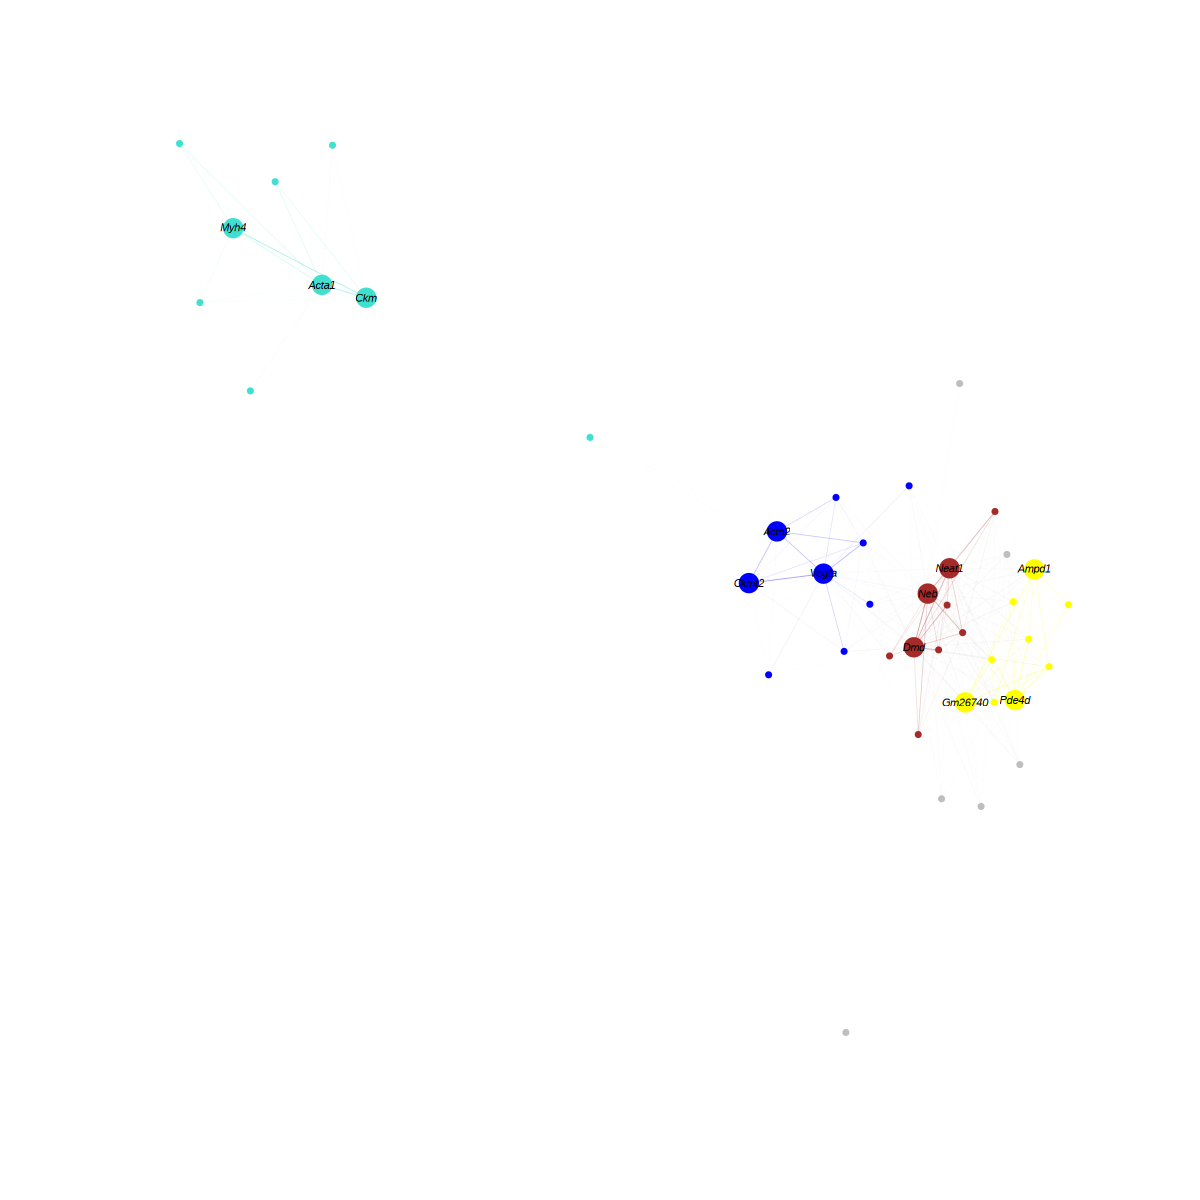

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
HubGeneNetworkPlot(
  Myo_sub,
  mods = "all", # all modules are plotted.
  n_hubs = 3,
  n_other=6,
  edge_prop = 0.75, 
)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



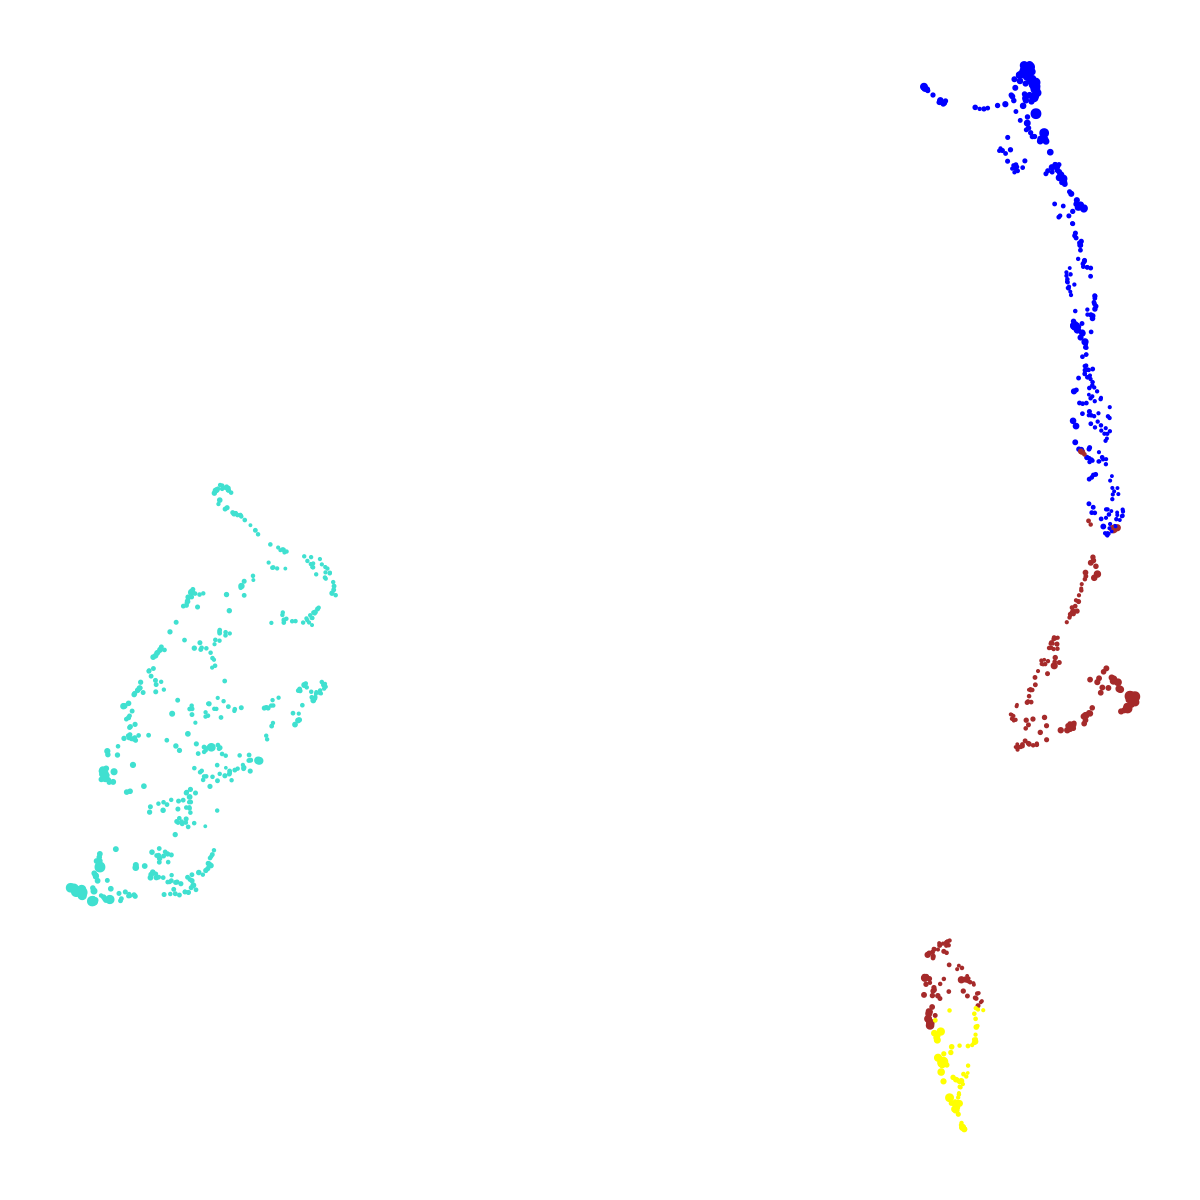

In [35]:
Myo_sub <- RunModuleUMAP(
  Myo_sub,
  n_hubs = 10, # number of hub genes to include for the UMAP embedding
  n_neighbors=15, # neighbors parameter for UMAP
  min_dist=0.1 # min distance between points in UMAP space
)
umap_df <- GetModuleUMAP(Myo_sub)

# plot with ggplot
ggplot(umap_df, aes(x=UMAP1, y=UMAP2)) +
  geom_point(
   color=umap_df$color, # color each point by WGCNA module
   size=umap_df$kME*2 # size of each point based on intramodular connectivity
  ) +
  umap_theme()

Selecting by kME_Myo_subWAT-M1
Selecting by kME_Myo_subWAT-M2
Selecting by kME_Myo_subWAT-M3
Selecting by kME_Myo_subWAT-M4


[1] "hub labels"
[1] "Actn2"   "Vegfa"   "Acta1"   "Myh4"    "Gm26740" "Pde4d"   "Neb"    
[8] "Dmd"    
NULL
[1] "Actn2"   "Vegfa"   "Acta1"   "Myh4"    "Gm26740" "Pde4d"   "Neb"    
[8] "Dmd"    
[1] 42280     3
[1] 1057    4


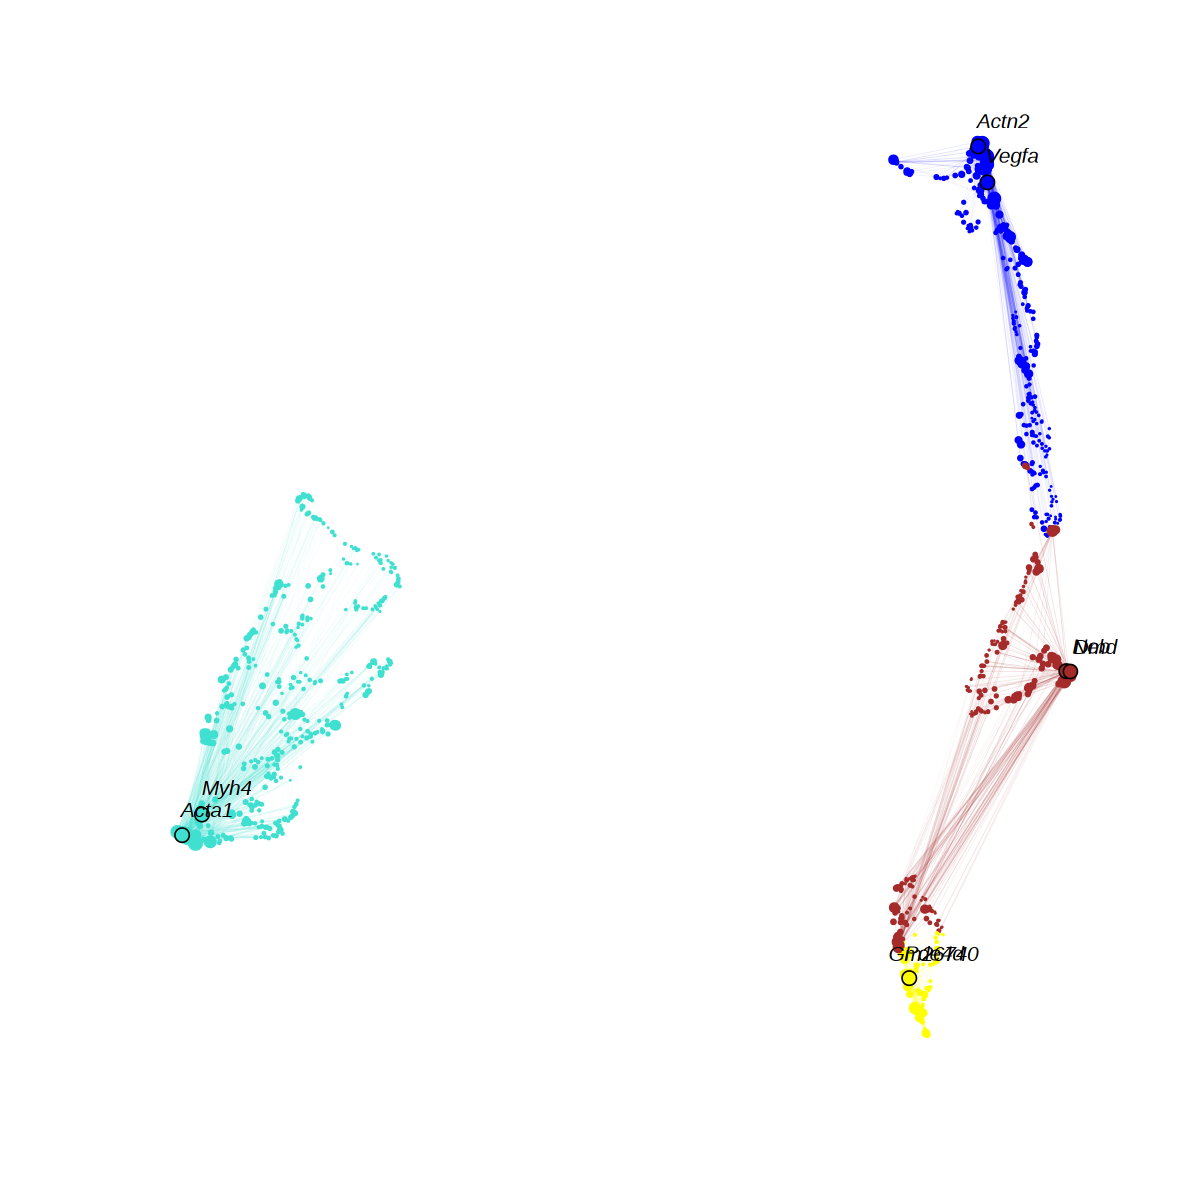

In [36]:
options(repr.plot.width = 10, repr.plot.height = 10)
ModuleUMAPPlot(
  Myo_sub,
  edge.alpha=0.25,
  sample_edges=TRUE,
  edge_prop=0.1, # proportion of edges to sample (20% here)
  label_hubs=2 ,# how many hub genes to plot per module?
  keep_grey_edges=FALSE,

)